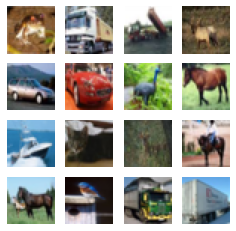

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label is not None:
        train_x = train_x[train_y.flatten() == label]
        test_x = test_x[test_y.flatten() == label]
    return train_x, test_x

train_x, _ = load_data()
train_x = (train_x - 127.5) / 127.5  # 정규화: [-1, 1]
BUFFER_SIZE = 50000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 시각화
plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow((train_x[i] + 1) / 2)  # 정규화 복구
    plt.axis('off')
plt.show()

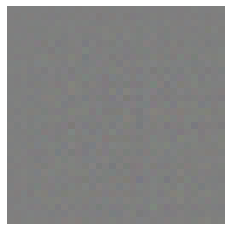

In [21]:
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = make_generator_model()

# 랜덤 노이즈로 이미지 생성
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0] + 1) / 2)
plt.axis('off')
plt.show()


In [22]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[32,32,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print("판별 결과 (logit):", decision)

판별 결과 (logit): tf.Tensor([[0.00491187]], shape=(1, 1), dtype=float32)


In [25]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [28]:
import os
import time
from IPython import display
import imageio
from PIL import Image
import glob

seed = tf.random.normal([16, 100])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

save_dir = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/generated_samples')
os.makedirs(save_dir, exist_ok=True)  # 혹시 없으면 디렉토리 생성

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1) / 2)
        plt.axis('off')

    filepath = os.path.join(save_dir, f'image_at_epoch_{epoch:04d}.png')
    plt.savefig(filepath)
    plt.close()
    
# draw_train_history()는 이렇게 수정
def draw_train_history(history):
    epochs = range(len(history['g_loss']))

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['g_loss'], label='Generator Loss')
    plt.plot(epochs, history['d_loss'], label='Discriminator Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['real_acc'], label='Real Accuracy')
    plt.plot(epochs, history['fake_acc'], label='Fake Accuracy')
    plt.legend()
    plt.title('Discriminator Accuracy')

    plt.tight_layout()

    history_dir = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/training_history')
    os.makedirs(history_dir, exist_ok=True)
    filepath = os.path.join(history_dir, 'training_history.png')
    plt.savefig(filepath)
    print(f"📊 학습 그래프 저장 완료: {filepath}")
    
    plt.show()  # 저장 이후 출력
    plt.close()
    
def generate_gif():
    img_dir = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/generated_samples')
    gif_path = os.path.join(img_dir, 'dcgan_cifar10.gif')

    img_paths = sorted(glob.glob(os.path.join(img_dir, 'image_at_epoch_*.png')))
    images = [imageio.imread(img_path) for img_path in img_paths]  # v2 없이 사용

    imageio.mimsave(gif_path, images, fps=5)  # 1초에 5장
    print(f"✅ GIF 저장 완료: {gif_path}")


Time for epoch 1 is 17.38 sec
Time for epoch 2 is 16.37 sec
Time for epoch 3 is 16.51 sec
Time for epoch 4 is 16.60 sec
Time for epoch 5 is 16.43 sec
Time for epoch 6 is 16.26 sec
Time for epoch 7 is 16.30 sec
Time for epoch 8 is 16.38 sec
Time for epoch 9 is 16.42 sec
💾 체크포인트 저장 완료: /aiffel/aiffel/dcgan_newimage/cifar10/training_checkpoints/ckpt
Time for epoch 10 is 16.49 sec
Time for epoch 11 is 16.33 sec
Time for epoch 12 is 16.29 sec
Time for epoch 13 is 18.48 sec
Time for epoch 14 is 16.45 sec
Time for epoch 15 is 16.46 sec
Time for epoch 16 is 16.40 sec
Time for epoch 17 is 16.33 sec
Time for epoch 18 is 16.80 sec
Time for epoch 19 is 16.44 sec
💾 체크포인트 저장 완료: /aiffel/aiffel/dcgan_newimage/cifar10/training_checkpoints/ckpt
Time for epoch 20 is 16.59 sec
Time for epoch 21 is 16.50 sec
Time for epoch 22 is 16.39 sec
Time for epoch 23 is 16.40 sec
Time for epoch 24 is 16.38 sec
💾 체크포인트 저장 완료: /aiffel/aiffel/dcgan_newimage/cifar10/training_checkpoints/ckpt
Time for epoch 30 is 16.49 s

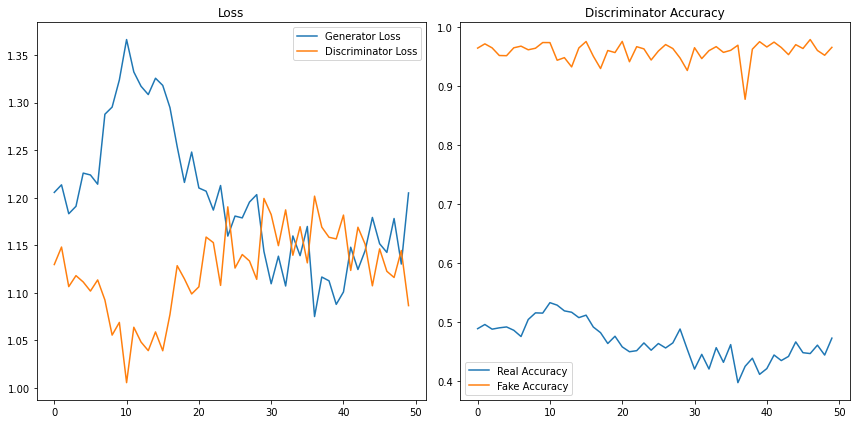

✅ GIF 저장 완료: /aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/dcgan_cifar10.gif
✅ 최신 체크포인트 로드 완료: /aiffel/aiffel/dcgan_newimage/cifar10/training_checkpoints/ckpt-5


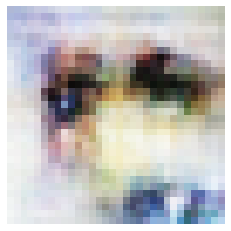

In [29]:
# 체크포인트 설정
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=generator,
                                 discriminator=discriminator)

EPOCHS = 50

history = {
    'g_loss': [],
    'd_loss': [],
    'real_acc': [],
    'fake_acc': []
}

for epoch in range(EPOCHS):
    start = time.time()

    g_losses, d_losses, real_accs, fake_accs = [], [], [], []

    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch)

        # (선택) Accuracy 계산 함수 따로 만들어 사용 가능
        real_acc = tf.reduce_mean(tf.cast(discriminator(image_batch, training=False) > 0.5, tf.float32))
        noise = tf.random.normal([BATCH_SIZE, 100])
        fake_images = generator(noise, training=False)
        fake_acc = tf.reduce_mean(tf.cast(discriminator(fake_images, training=False) < 0.5, tf.float32))

        g_losses.append(gen_loss)
        d_losses.append(disc_loss)
        real_accs.append(real_acc)
        fake_accs.append(fake_acc)

    # Epoch 평균 기록
    history['g_loss'].append(np.mean(g_losses))
    history['d_loss'].append(np.mean(d_losses))
    history['real_acc'].append(np.mean(real_accs))
    history['fake_acc'].append(np.mean(fake_accs))

    # 이미지 저장
    generate_and_save_images(generator, epoch+1, seed)

    # 💾 매 10 epoch마다 모델 저장
    if (epoch + 1) % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
        print(f"💾 체크포인트 저장 완료: {checkpoint_prefix}")

    print(f'Time for epoch {epoch+1} is {time.time()-start:.2f} sec')

# 학습 종료 후 처리
draw_train_history(history)  # 학습 그래프 저장
generate_gif()  # GIF 생성

# 💾 최신 체크포인트 불러오기
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)
print(f"✅ 최신 체크포인트 로드 완료: {latest}")

# 랜덤 노이즈로 이미지 생성 및 출력
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0] + 1) / 2)
plt.axis('off')
plt.show()